In [ ]:
%pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
%pip install fedml
%pip install scikit-learn pandas
%pip install imbalanced-learn
%pip install matplotlib seaborn
%pip install tqdm

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip uninstall torch torchvision torchaudio -ypip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118



Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\Bikram\AppData\Local\Programs\Python\Python310\python.exe -m pip uninstall [options] <package> ...
  c:\Users\Bikram\AppData\Local\Programs\Python\Python310\python.exe -m pip uninstall [options] -r <requirements file> ...

no such option: -p


In [3]:
%pip install opacus==1.3.0


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
#  Differential Privacy with Opacus
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager
#  Federated Learning (FedML)
from fedml import FedMLRunner  # Entry point — you’ll define your own runner or logic
#  Data Handling and ML Evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
#  Imbalanced Data Handling
from imblearn.over_sampling import SMOTE, ADASYN
#  Visualization
import matplotlib.pyplot as plt
import seaborn as sns
#  Progress Bar
from tqdm import tqdm
#  System & Debugging
import os
import random
import warnings
warnings.filterwarnings("ignore")
#  Check GPU device
print(" Torch version:", torch.__version__)
print(" CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(" GPU device:", torch.cuda.get_device_name(0))


 Torch version: 2.0.1+cu118
 CUDA available: True
 GPU device: NVIDIA T1000 8GB


Define Global Configurations



In [ ]:
import torch
import random
import numpy as np

#  Global configurations for the entire experiment
class Args:
    # Data and model config
    image_size = 224
    num_classes = 3  # 0: COVID, 1: Pneumonia, 2: Normal
    batch_size = 32
    lr = 0.01
    epochs = 7
    noise_multiplier = 1.0
    max_grad_norm = 1.0
    delta = 1e-5  # For epsilon calculation

    round_count = 10              
    client_sizes = [3, 7, 10, 13]  
    initial_clients = 6           
    drop_rate = 0.2                
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Seed for reproducibility
    seed = 42

# Instantiate config
args = Args()

# Optional: Set global random seed for reproducibility
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

print("Configuration loaded. Using device:", args.device)


Configuration loaded. Using device: cuda


Load and Clean dataset


In [ ]:
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import os
import random

#  Define transform pipeline (resize, normalize like ImageNet)
img_transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#  Step 1: Collect image file paths and labels (very low memory)
def collect_image_paths(folder_path, label):
    dataset = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(folder_path, fname)
            dataset.append((img_path, label))
    return dataset

#  Step 2: Define dataset paths
covid_path = "COVID-19_Radiography_Dataset"
covid_images = collect_image_paths(os.path.join(covid_path, "COVID/images"), label=0)
viral_images = collect_image_paths(os.path.join(covid_path, "Viral_Pneumonia/images"), label=1)
lung_opacity_images = collect_image_paths(os.path.join(covid_path, "Lung_Opacity/images"), label=1)
normal_images_covid = collect_image_paths(os.path.join(covid_path, "Normal/images"), label=2)

pneu_path = "chest_xray"
normal_images_pneu = collect_image_paths(os.path.join(pneu_path, "train/NORMAL"), label=2)
pneumonia_images = collect_image_paths(os.path.join(pneu_path, "train/PNEUMONIA"), label=1)

#  Step 3: Merge all path+label pairs
all_image_paths = (
    covid_images +
    viral_images +
    lung_opacity_images +
    normal_images_covid +
    normal_images_pneu +
    pneumonia_images
)

print(f" Total image paths collected: {len(all_image_paths)}")

#  Step 4: Split data into train and test (80-20 split)
def split_train_test(data, test_size=0.2, random_state=42):
    """
    Split data into train and test sets while maintaining label distribution
    """
    # Separate paths and labels
    paths = [item[0] for item in data]
    labels = [item[1] for item in data]
    
    # Stratified split to maintain class distribution
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        paths, labels, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=labels
    )
    
    # Recombine paths and labels
    train_data = list(zip(train_paths, train_labels))
    test_data = list(zip(test_paths, test_labels))
    
    return train_data, test_data

#  Perform train-test split
train_image_paths, test_image_paths = split_train_test(all_image_paths, test_size=0.2, random_state=42)

print(f" Train set size: {len(train_image_paths)} samples")
print(f" Test set size: {len(test_image_paths)} samples")

def print_class_distribution(data, dataset_name):
    class_counts = {}
    for _, label in data:
        class_counts[label] = class_counts.get(label, 0) + 1
    
    print(f"\n {dataset_name} class distribution:")
    class_names = {0: "COVID", 1: "Pneumonia", 2: "Normal"}
    for label, count in class_counts.items():
        print(f"   {class_names[label]} (Label {label}): {count} samples")

print_class_distribution(train_image_paths, "Training")
print_class_distribution(test_image_paths, "Testing")

class XrayLazyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path_or_img, label = self.data[idx]
        try:
            if isinstance(path_or_img, str):
                # 🧾 It's a file path
                img = Image.open(path_or_img).convert("RGB")
            else:
                # 🖼️ It's already a PIL.Image
                img = path_or_img

            if self.transform:
                img = self.transform(img)
            return img, label

        except Exception as e:
            print(f"⚠️ Skipping {path_or_img} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self.data))  

train_dataset = XrayLazyDataset(train_image_paths, transform=img_transform)
test_dataset = XrayLazyDataset(test_image_paths, transform=img_transform)

print(f" Training dataset ready with {len(train_dataset)} samples.")
print(f" Testing dataset ready with {len(test_dataset)} samples.")

def create_client_datasets(train_data, test_data, num_clients):
    """
    Distribute train and test data among multiple clients
    Each client gets a portion of both train and test data
    """
    # Shuffle data for random distribution
    random.shuffle(train_data)
    random.shuffle(test_data)
    
    # Calculate samples per client
    train_samples_per_client = len(train_data) // num_clients
    test_samples_per_client = len(test_data) // num_clients
    
    client_datasets = {}
    
    for client_id in range(num_clients):
        # Calculate start and end indices for this client
        train_start = client_id * train_samples_per_client
        train_end = (client_id + 1) * train_samples_per_client if client_id < num_clients - 1 else len(train_data)
        
        test_start = client_id * test_samples_per_client
        test_end = (client_id + 1) * test_samples_per_client if client_id < num_clients - 1 else len(test_data)
        
        # Create client-specific data
        client_train_data = train_data[train_start:train_end]
        client_test_data = test_data[test_start:test_end]
        
        # Create datasets for this client
        client_train_dataset = XrayLazyDataset(client_train_data, transform=img_transform)
        client_test_dataset = XrayLazyDataset(client_test_data, transform=img_transform)
        
        client_datasets[f'client_{client_id}'] = {
            'train': client_train_dataset,
            'test': client_test_dataset
        }
        
        print(f" Client {client_id}: Train={len(client_train_dataset)}, Test={len(client_test_dataset)}")
    
    return client_datasets

✅ Total image paths collected: 26381
✅ Train set size: 21104 samples
✅ Test set size: 5277 samples

📊 Training class distribution:
   Pneumonia (Label 1): 8985 samples
   Normal (Label 2): 9226 samples
   COVID (Label 0): 2893 samples

📊 Testing class distribution:
   COVID (Label 0): 723 samples
   Pneumonia (Label 1): 2247 samples
   Normal (Label 2): 2307 samples
✅ Training dataset ready with 21104 samples.
✅ Testing dataset ready with 5277 samples.


Plot the distribution


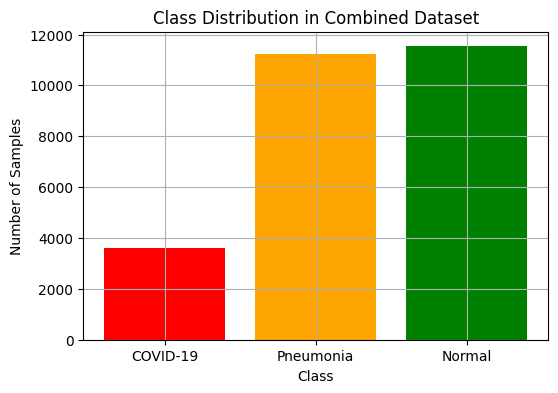

 Label counts: Counter({'Normal': 11533, 'Pneumonia': 11232, 'COVID-19': 3616})


In [7]:
import matplotlib.pyplot as plt
from collections import Counter

# Use the already collected image paths and labels
all_labels = [label for _, label in all_image_paths]

# Label mapping for display
label_map = {0: "COVID-19", 1: "Pneumonia", 2: "Normal"}
label_names = [label_map[l] for l in all_labels]

# Count and plot
counter = Counter(label_names)

plt.figure(figsize=(6, 4))
plt.bar(counter.keys(), counter.values(), color=["red", "orange", "green"])
plt.title("Class Distribution in Combined Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

print(" Label counts:", counter)


Data Agumentation

In [8]:
#  Cell 5: Define Image-Level Augmentation Transforms (no SMOTE here)

from torchvision import transforms

# Basic transform: no augmentation (for test/val)
base_transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Augmented transform: for training or oversampled data (COVID)
augmented_transform = transforms.Compose([
    transforms.Resize((args.image_size, args.image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

print(" Augmentation transforms defined. SMOTE will be applied per client in Cell 6.")


 Augmentation transforms defined. SMOTE will be applied per client in Cell 6.


Split the data among the clients and smote the minority class

In [9]:
import random
from collections import defaultdict, Counter
from PIL import Image
from torchvision import transforms

# Define COVID-specific augmentation
covid_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
])

# Step 1: Organize image paths by class
label_map = {0: "COVID", 1: "Pneumonia", 2: "Normal"}
class_data = defaultdict(list)

for path, label in all_image_paths:
    class_data[label].append((path, label))

print("Original class counts:")
for lbl, items in class_data.items():
    print(f" - {label_map[lbl]}: {len(items)}")

# Step 2: Augment COVID class to match max class size
target_class_size = max(len(v) for v in class_data.values())
augmented_covid_data = class_data[0].copy()

while len(augmented_covid_data) < target_class_size:
    img_path, label = random.choice(class_data[0])
    try:
        img = Image.open(img_path).convert("RGB")
        aug_img = covid_augment(img)
        augmented_covid_data.append((aug_img, label))  # Save PIL image + label
    except Exception as e:
        print(f" Augmentation failed on {img_path}: {e}")

# Step 3: Combine all class data
combined_dataset = (
    augmented_covid_data +
    class_data[1] +  # Pneumonia
    class_data[2]    # Normal
)

random.shuffle(combined_dataset)
print(f" Combined + balanced dataset size: {len(combined_dataset)}")

# Step 4: Split among clients (with train-test split)
def split_among_clients(dataset, num_clients, train_ratio=0.8):
    random.shuffle(dataset)
    total = len(dataset)
    split_size = total // num_clients
    clients = {}

    for i in range(num_clients):
        start = i * split_size
        end = (i + 1) * split_size if i != num_clients - 1 else total
        client_data = dataset[start:end]

        # Train-test split
        split_idx = int(train_ratio * len(client_data))
        train_data = client_data[:split_idx]
        test_data = client_data[split_idx:]

        clients[i] = {
            'train': train_data,
            'test': test_data
        }

        print(f"Client {i}: {len(train_data)} train, {len(test_data)} test samples")

    return clients

client_datasets = split_among_clients(combined_dataset, args.initial_clients)

print(f" Created {args.initial_clients} federated clients with train-test splits.")


Original class counts:
 - COVID: 3616
 - Pneumonia: 11232
 - Normal: 11533
 Combined + balanced dataset size: 34298
Client 0: 4572 train, 1144 test samples
Client 1: 4572 train, 1144 test samples
Client 2: 4572 train, 1144 test samples
Client 3: 4572 train, 1144 test samples
Client 4: 4572 train, 1144 test samples
Client 5: 4574 train, 1144 test samples
 Created 6 federated clients with train-test splits.


Load and Customize DenseNet121

In [10]:
#  Cell 7: Load ResNet18 with GroupNorm
from torchvision import models
import torch.nn as nn
# Helper: replace all BatchNorm2d with GroupNorm 
def convert_bn_to_gn(model, num_groups=2):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, nn.GroupNorm(num_groups, module.num_features))
        else:
            convert_bn_to_gn(module, num_groups=num_groups)
    return model

def get_resnet18_model(num_classes):
    model = models.resnet18(pretrained=True)
    model = convert_bn_to_gn(model)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(args.device)
global_model = get_resnet18_model(num_classes=args.num_classes)

print(f" ResNet18 with GroupNorm ready for {args.num_classes} classes on {args.device}")


 ResNet18 with GroupNorm ready for 3 classes on cuda


Local Training with Opacus

In [11]:
from opacus import PrivacyEngine
from torch.utils.data import DataLoader
import copy
import torch
import torch.nn as nn

def train_local_model(client_id, model, train_data, test_data, args):
    # Deep copy the global model
    model = copy.deepcopy(model).to(args.device)
    model.train()

    # Dataloaders
    train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

    # Optimizer and loss
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr)
    criterion = nn.CrossEntropyLoss()

    # Attach Privacy Engine
    privacy_engine = PrivacyEngine()
    model, optimizer, train_loader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        noise_multiplier=args.noise_multiplier,
        max_grad_norm=args.max_grad_norm,
    )

    # Training loop
    for epoch in range(args.epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(args.device), labels.to(args.device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[Client {client_id}] Epoch {epoch+1}/{args.epochs}, Loss: {running_loss:.4f}")

    # Evaluation on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(args.device), labels.to(args.device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    print(f"[Client {client_id}] Test Accuracy: {acc:.2f}%")

    # Privacy accounting
    epsilon = privacy_engine.get_epsilon(delta=args.delta)
    print(f"[Client {client_id}] Training done. ε = {epsilon:.2f}")

    return model.state_dict(), epsilon


FedAvg


In [12]:
import copy
def fed_avg(client_weights):
    # Deep copy the first client's weights
    avg_weights = copy.deepcopy(client_weights[0])

    # Sum all the client weights
    for key in avg_weights.keys():
        for i in range(1, len(client_weights)):
            avg_weights[key] += client_weights[i][key]
        avg_weights[key] = avg_weights[key] / len(client_weights)

    return avg_weights


Inttermittent Client Updates

In [13]:
def select_clients(client_datasets, round_idx, drop_rate=0.2, seed=None):
    total_clients = len(client_datasets)
    available_clients = list(client_datasets.keys())

    # Optional: reproducible random selection
    if seed is not None:
        random.seed(seed + round_idx)  # Different pattern each round, but reproducible
    elif hasattr(args, "seed"):
        random.seed(args.seed + round_idx)

    # Drop a portion of clients
    num_drop = int(total_clients * drop_rate)
    random.shuffle(available_clients)
    selected_clients = available_clients[num_drop:]

    print(f"🔁 Round {round_idx+1}: Selected {len(selected_clients)} out of {total_clients} clients")
    return selected_clients


Training loop

In [ ]:
import os
import time
import copy
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
import random

# Constants
NUM_CLASSES = 3
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Dataset that handles both file paths and PIL images
class XrayLazyDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.image_label_list = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.image_label_list)

    def __getitem__(self, idx):
        image_or_path, label = self.image_label_list[idx]

        if isinstance(image_or_path, str):
            image = Image.open(image_or_path).convert("RGB")
        elif isinstance(image_or_path, Image.Image):
            image = image_or_path
        else:
            raise ValueError(f"Unsupported image type: {type(image_or_path)}")

        if self.transform:
            image = self.transform(image)

        return image, label

# Strip Opacus prefixes if present
def strip_opacus_prefix(state_dict):
    return {k.replace("_module.", ""): v for k, v in state_dict.items()}

# Model evaluation
def evaluate_model(model, dataset, args):
    model.eval()
    loader = DataLoader(dataset, batch_size=args.batch_size)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(args.device), labels.to(args.device)

            if not torch.all((labels >= 0) & (labels < NUM_CLASSES)):
                print(f" Invalid labels found: {labels}")
                continue

            outputs = model(images)
            if outputs.shape[1] != NUM_CLASSES:
                raise RuntimeError(f" Model output shape {outputs.shape[1]} ≠ NUM_CLASSES {NUM_CLASSES}")

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Load the latest saved global model if exists
def load_latest_model(global_model):
    files = [f for f in os.listdir('.') if f.startswith('global_model_round_') and f.endswith('.pt')]
    if not files:
        return 0  # No previous round
    
    latest_round = max([int(f.split('_')[-1].split('.')[0]) for f in files])
    latest_file = f"global_model_round_{latest_round}.pt"
    print(f"Loading model from {latest_file}")
    global_model.load_state_dict(torch.load(latest_file))
    return latest_round

# Federated training
start_round = load_latest_model(global_model)
global_weights = global_model.state_dict()
epsilon_tracker = []
round_times = []
test_accuracies = []

for round_idx in range(start_round, args.round_count):
    print(f"\n -------- Federated Round {round_idx + 1} --------")

    selected_clients = select_clients(client_datasets, round_idx, drop_rate=args.drop_rate)
    client_weights = []
    epsilons = []
    round_test_acc = []

    start_time = time.time()

    for client_id in selected_clients:
        client_data = client_datasets[client_id]

        client_data_list = client_data['train'] + client_data['test']
        client_data_list = [
            (p, l) for (p, l) in client_data_list
            if (isinstance(p, str) and os.path.isfile(p)) or isinstance(p, Image.Image)
        ]

        if len(client_data_list) == 0:
            print(f"[Skip] Client {client_id} has no valid data.")
            continue

        full_dataset = XrayLazyDataset(client_data_list, transform=img_transform)
        train_len = int(0.8 * len(full_dataset))
        test_len = len(full_dataset) - train_len
        train_dataset, test_dataset = random_split(full_dataset, [train_len, test_len])

        updated_weights, epsilon = train_local_model(client_id, global_model, train_dataset, test_dataset, args)
        client_weights.append(updated_weights)
        epsilons.append(epsilon)

        temp_model = copy.deepcopy(global_model).to(args.device)
        temp_model.load_state_dict(strip_opacus_prefix(updated_weights))
        acc = evaluate_model(temp_model, test_dataset, args)
        round_test_acc.append(acc)
        print(f"[Client {client_id}]  Test Accuracy: {acc:.2f}%")

    if client_weights:
        global_weights = fed_avg(client_weights)
        global_weights = strip_opacus_prefix(global_weights)
        global_model.load_state_dict(global_weights)

        avg_epsilon = sum(epsilons) / len(epsilons)
        avg_test_acc = sum(round_test_acc) / len(round_test_acc)
        epsilon_tracker.append(avg_epsilon)
        test_accuracies.append(avg_test_acc)

        round_time = time.time() - start_time
        round_times.append(round_time)

        print(f" Round {round_idx + 1} complete. Avg ε = {avg_epsilon:.2f}, Avg Test Acc = {avg_test_acc:.2f}% | Time: {round_time:.1f}s")

        # Global model evaluation
        combined_test_data = []
        for cid, cdata in client_datasets.items():
            combined_test_data += [
                (p, l) for (p, l) in cdata['test']
                if (isinstance(p, str) and os.path.isfile(p)) or isinstance(p, Image.Image)
            ]

        if len(combined_test_data) > 0:
            global_test_dataset = XrayLazyDataset(combined_test_data, transform=img_transform)
            global_test_acc = evaluate_model(global_model.to(args.device), global_test_dataset, args)
            print(f"  Global Model Accuracy (All Clients' Test Sets): {global_test_acc:.2f}%")
        else:
            print(" No valid test data found for global model evaluation.")

        # Save global model
        torch.save(global_model.state_dict(), f"global_model_round_{round_idx+1}.pt")
        print(f" Saved global model to global_model_round_{round_idx+1}.pt")
    else:
        print(" No valid client updates this round. Skipping FedAvg.")

print("\n Federated training finished.")


Loading model from global_model_round_7.pt

 -------- Federated Round 8 --------
🔁 Round 8: Selected 5 out of 6 clients
[Client 1] Epoch 1/7, Loss: 126.7939
[Client 1] Epoch 2/7, Loss: 132.6227
[Client 1] Epoch 3/7, Loss: 131.6891
[Client 1] Epoch 4/7, Loss: 117.0214
[Client 1] Epoch 5/7, Loss: 118.6948
[Client 1] Epoch 6/7, Loss: 131.2405
[Client 1] Epoch 7/7, Loss: 132.0727
[Client 1] Test Accuracy: 69.14%
[Client 1] Training done. ε = 1.25
[Client 1]  Test Accuracy: 69.14%
[Client 5] Epoch 1/7, Loss: 125.4397
[Client 5] Epoch 2/7, Loss: 128.6901
[Client 5] Epoch 3/7, Loss: 132.1705
[Client 5] Epoch 4/7, Loss: 123.3298
[Client 5] Epoch 5/7, Loss: 130.3756
[Client 5] Epoch 6/7, Loss: 131.8602
[Client 5] Epoch 7/7, Loss: 124.6350
[Client 5] Test Accuracy: 69.14%
[Client 5] Training done. ε = 1.25
[Client 5]  Test Accuracy: 69.14%
[Client 3] Epoch 1/7, Loss: 128.6995
[Client 3] Epoch 2/7, Loss: 126.2107
[Client 3] Epoch 3/7, Loss: 121.5545
[Client 3] Epoch 4/7, Loss: 124.0016
[Client 3]

KeyboardInterrupt: 